In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random 

In [2]:
class Persona:
    def __init__(self,resource,productivity,science,wealth,income,saving,salary,InvestIncome,lifestatus,
                GainedInvest,PayInvest,WorkIncome,empleados,status,indice,production,clase,consumption):
        self.resource=resource
        self.productivity=productivity
        self.science=science
        self.wealth=wealth
        self.income=income
        self.saving=saving
        self.salary=salary
        self.InvestIncome=InvestIncome
        self.GainedInvest=GainedInvest
        self.PayInvest=PayInvest
        self.lifestatus=lifestatus #0->vivo #1-> muerto
        self.WorkIncome=WorkIncome
        self.empleados=empleados
        self.status=status #0->empleado #2->investor #1->ni empleado ni investor
        self.indice=indice
        self.production=production
        self.clase=clase
        self.consumption=consumption
    #asignar indice
    def a_indice(self,i):
        self.indice=i
    #calcular productivity
    def initial_productivity(self,mean,desviacion,t):
        p=random.gauss(mean,desviacion)
        if (p>0):
            self.productivity[t]=p
    #calcular production inicial
    def initial_production(self,t):
        self.production[t]=self.resource*self.productivity[t]*self.science
    def initial_wealth(self,i_wealth,t):
        self.wealth[t]=i_wealth
    def initial_saving(self,i_sav,t):
        self.saving[t]=i_sav
    #introducir empleados si es investor
    def guardar_empleado(self,identificador): #me va a guardar el indice de cada empleado
        self.empleados.append(identificador)

    


In [3]:
#calcular productividad para cada año
def c_productivity(agentes,t):
    for i in range(len(agentes)):
        if (agentes[i].lifestatus==0):
            agentes[i].productivity[t]=agentes[i].productivity[t-1]

In [4]:
#calcular production
def c_production(agentes,t):
    for i in range(len(agentes)):
        if (agentes[i].lifestatus==0):
            produc=agentes[i].resource*agentes[i].productivity[t]*agentes[i].science
            agentes[i].production[t]=produc

In [5]:
#calcular workIncome
def c_workincome(agentes,t):
    for i in range(len(agentes)):
        if (agentes[i].lifestatus==0):
            if (agentes[i].status==2): #si es inversionista
                agentes[i].WorkIncome[t]=agentes[i].production[t]
            if (agentes[i].status==0): #si es empleado agregar status 3
                agentes[i].WorkIncome[t]=agentes[i].salary
            if (agentes[i].status==1): #si no es empleado ni inversionista
                agentes[i].WorkIncome[t]=agentes[i].production[t]

In [6]:
#creamos una funcion para definir el investincome
def c_investincome(agentes,t):
    invest=0
    for j in range(len(agentes)):
        if (agentes[j].status==2 and agentes[j].lifestatus==0):
            for k in agentes[j].empleados:
                invest=invest+agentes[k].production[t]-agentes[k].salary
            agentes[j].InvestIncome[t]=invest


In [7]:
#creamos una funcion para el income
def c_income(agentes,t):
    for i in range(len(agentes)):
        if (agentes[i].lifestatus==0):
            inc=agentes[i].WorkIncome[t]+agentes[i].InvestIncome[t]
            agentes[i].income[t]=inc

In [8]:
#creamos una funcion para wealth
def c_wealth(agentes,t,tau):
    for i in range(len(agentes)):
        if (agentes[i].lifestatus==0):
            w=agentes[i].income[t]+agentes[i].saving[t-1]*(1-1.0/tau)
            agentes[i].wealth[t]=w

In [9]:
#creamos funcion de distribucion de clase [0 alive,1 enough,2 satisfied,3 luxury]
def dist_clase(lista_consumo,agentes,t):
    for i in range(len(agentes)):
        if(agentes[i].lifestatus==0):
            for s in range(len(lista_consumo)):
                if (s!=len(lista_consumo)-1):
                    min=lista_consumo[s]
                    max=lista_consumo[s+1]
                    if (agentes[i].wealth[t]>=min and agentes[i].wealth[t]<max):
                        agentes[i].clase=s
                if (s==len(lista_consumo)-1):
                    if (agentes[i].wealth[t]>=max):
                         agentes[i].clase=s
            if (agentes[i].wealth[t]<lista_consumo[0]):
                    ind=agentes[i].indice
                    #print(ind,t)
                    broke_sale(ind,agentes,lista_consumo[0],5000,t)

In [20]:
#asignar consumo a cada uno
def asignar_consumo(agentes,lista_consumo,t):
    l_desviaciones=[500,1500,4*10**4,2*10**5]
    for i in range(len(agentes)):
        if(agentes[i].lifestatus==0):
            for s in range(len(lista_consumo)):
                if agentes[i].clase==s:
                    c=np.abs(random.gauss(0,l_desviaciones[s]))
                    consumo=lista_consumo[s]+c
                    if (consumo>=lista_consumo[s] and consumo<agentes[i].wealth[t]):
                        agentes[i].consumption[t]=consumo
                    if (consumo<lista_consumo[s] or consumo>agentes[i].wealth[t]):
                        agentes[i].consumption[t]=lista_consumo[s]
                    if (agentes[i].wealth[t]<lista_consumo[0]): #si esta muerto
                        agentes[i].consumption[t]=0

In [11]:
#creamos funcion para contar el numero de agentes en cada clase
def conteo_clase(agentes,clase0,clase1,clase2,clase3,t):
    s0=0
    s1=0
    s2=0
    s3=0
    for i in range(len(agentes)):
        if agentes[i].clase==0:
            s0=s0+1
        if agentes[i].clase==1:
            s1=s1+1
        if agentes[i].clase==2:
            s2=s2+1
        if agentes[i].clase==3:
            s3=s3+1
    clase0[t]=s0
    clase1[t]=s1
    clase2[t]=s2
    clase3[t]=s3    

In [12]:
#funcion de interaccion tipo Broke sale
def broke_sale(i,agentes,e_alive,e_satisfied,t):
    
#for j in range(len(agentes)):
    if(agentes[i].wealth[t]<e_alive):
        j=random.randint(0,len(agentes)-1)
        expected_productivity=0
        expected_production=0
        if(i!=j and agentes[j].wealth[t]>=1*10**4):
            expected_productivity=np.divide(agentes[i].productivity[t]+agentes[j].productivity[t],2)
            expected_production=agentes[i].resource*expected_productivity*agentes[i].science
        #print('riqueza i antes de broke sale',agentes[i].wealth[t],t)
        if (expected_production-e_alive>0 and agentes[j].status!=0):
            #agentes[j].resource[t]=agentes[j].resource[t]+agentes[i].resource[t]
            #agentes[i].resource[t]=1
            #venta del recurso
            #print('riqueza j antes de broke sale',agentes[j].wealth[t])
            #print('i',i,'j',j,'t',t)
            agentes[i].GainedInvest[t]=e_alive
            #cambio en la energia
            #agentes[i].wealth[t]=agentes[i].wealth[t]+e_alive
            #agentes[j].wealth[t]=agentes[j].wealth[t]-e_alive
            #print('riqueza i despues bsale',agentes[i].wealth[t])
            #print('riqueza j despues bsale',agentes[j].wealth[t])
            #cambia la productividad
            agentes[i].productivity[t]=np.divide(agentes[i].productivity[t]+agentes[j].productivity[t],2)
            #agentes[i].c_production(t)
            agentes[i].salary=e_alive
            agentes[j].guardar_empleado(agentes[i].indice)
            setattr(agentes[i],'status',0)#cambiar status->empleado
            setattr(agentes[j],'status',2)#cambiar status->investor


In [13]:
#funcion para borrar personas que mueren
def borrar_agente(agentes,e_alive,t):
    for i in range(len(agentes)):
        if (agentes[i].wealth[t]<e_alive and agentes[i].status!=0):
            setattr(agentes[i],'lifestatus',1) #pasar su estado a muerto
            #print('agente que murio',agente.indice)
            #print('life status agente muerto',agente.lifestatus)
            #print('año de muerte',t)


In [14]:
#calcular PayInvest
def pay_invest(agentes,t):
    pi=0
    for j in range(len(agentes)):
        if (agentes[j].status==2 and agentes[j].lifestatus==0):
            for k in agentes[j].empleados:
                pi=pi+agentes[k].GainedInvest[t]
                #print('cada paso de tiempo',pi)
            agentes[j].PayInvest[t]=pi
            #print('final pi',pi)
            pi=0
        #print('pi vaciado',pi)

In [15]:
#calcular saving
def c_saving(agentes,t):
    sav=0
    for i in range(len(agentes)):
        if(agentes[i].lifestatus==0):
            sav=agentes[i].wealth[t]+agentes[i].GainedInvest[t]-agentes[i].consumption[t]-agentes[i].PayInvest[t]
            #print(sav,t)
            agentes[i].saving[t]=sav
            '''
        if (agentes[i].status==0):
            sav=agentes[i].wealth[t]-2500+agentes[i].GainedInvest[t]-agentes[i].consumption[t]-agentes[i].PayInvest[t]
            agentes[i].saving[t]=sav
        if (agentes[i].status==1 and agentes[i].wealth[t]>=2500):
            sav=agentes[i].wealth[t]+agentes[i].GainedInvest[t]-agentes[i].consumption[t]-agentes[i].PayInvest[t]
            agentes[i].saving[t]=sav
        if (agentes[i].status==1 and agentes[i].wealth[t]<2500):
            sav=0
            agentes[i].saving[t]=sav
        '''

In [25]:
#Inicializacion por defecto creamos un vector de objetos y lo llenamos
#random.seed(0)
poblacion=[]#array de objetos que tiene a cada persona
N=1*10**3
n_tsteps=40
empleados_per=[]
l_production=np.zeros(n_tsteps)
l_workincome=np.zeros(n_tsteps)
l_investincome=np.zeros(n_tsteps)
l_gainedinvest=np.zeros(n_tsteps)
l_payinvest=np.zeros(n_tsteps)
l_income=np.zeros(n_tsteps)
l_wealth=np.zeros(n_tsteps)
l_saving=np.zeros(n_tsteps)
l_consumption=np.zeros(n_tsteps)
l_productivity=np.zeros(n_tsteps)
l_alive=np.zeros(n_tsteps)
l_enough=np.zeros(n_tsteps)
l_satisfied=np.zeros(n_tsteps)
l_luxury=np.zeros(n_tsteps)
'''
Persona(self,resource,productivity,science,wealth,income,saving,salary,InvestIncome,lifestatus,
                GainedInvest,PayInvest,WorkIncome,empleados,status,indice,production,clase,consumption):
'''   
#para ---t=0-------
for i in range(N):
    per=Persona(1,l_productivity,1,l_wealth,l_income,l_saving,0,l_investincome,0,l_gainedinvest
                ,l_payinvest,l_workincome,empleados_per,1,0,l_production,0,l_consumption)
    poblacion.append(per) #introducimos cada objeto en el array
    poblacion[i].a_indice(i)#le asignamos su indice a cada uno
    poblacion[i].initial_productivity(5000,5000,0)#calculamos la productividad para cada uno mean y sd 5000
    poblacion[i].initial_production(0) #calculamos la produccion segun productivity
    poblacion[i].initial_wealth(5000,0)#asignamos inicialmente a todos la misma riqueza 5000
    poblacion[i].initial_saving(5000,0)#el mismo ahorro inicial 5000
    #poblacion[i].c_production(1)#calculamos la del año 1
    l_workincome=np.zeros(n_tsteps)
    l_production=np.zeros(n_tsteps)
    l_workincome=np.zeros(n_tsteps)
    l_investincome=np.zeros(n_tsteps)
    l_gainedinvest=np.zeros(n_tsteps)
    l_payinvest=np.zeros(n_tsteps)
    l_income=np.zeros(n_tsteps)
    l_wealth=np.zeros(n_tsteps)
    l_saving=np.zeros(n_tsteps)
    l_consumption=np.zeros(n_tsteps)
    l_productivity=np.zeros(n_tsteps)
    empleados_per=[]
conteo_clase(poblacion,l_alive,l_enough,l_satisfied,l_luxury,0)

In [ ]:
print(poblacion[0].production)
print(poblacion[1].production)
print(poblacion[2].production)

In [26]:
#----para t=1 hasta n_timesteps-1-----
#for t in range(1,n_timesteps,1):
#para t=1
random.seed(0)
lista_clase=[2500,7500,2*10**5,10**6]
for t in range(1,n_tsteps,1):
    #---primer paso------(1)
    c_productivity(poblacion,t)
    c_production(poblacion,t)
    c_workincome(poblacion,t)
    c_investincome(poblacion,t) 
    c_income(poblacion,t)
    c_wealth(poblacion,t,2)
    #---segundo paso-----(2) dist. clase
    dist_clase(lista_clase,poblacion,t)
    borrar_agente(poblacion,lista_clase[0],t)
    c_production(poblacion,t)#calculamos de nuevo production pues cambio la productividad
    asignar_consumo(poblacion,lista_clase,t)
    #----tercer paso------(3)payinvest
    pay_invest(poblacion,t)
    #----cuarto paso-----(4) saving
    c_saving(poblacion,t)
    conteo_clase(poblacion,l_alive,l_enough,l_satisfied,l_luxury,t)

for i in range(len(poblacion)):
    
    #print('workincome'+str(i),poblacion[i].WorkIncome)
    #print('investincome'+ str(i),poblacion[i].InvestIncome)
    #print('income'+str(i),poblacion[i].income)
    #print('wealth'+str(i),poblacion[i].wealth)
    #print('clase'+str(i),poblacion[i].clase)
    #print('gainedinvest'+str(i),poblacion[i].GainedInvest)
    #print('consumo'+str(i),poblacion[i].consumption)
    #print('payinvest'+str(i),poblacion[i].PayInvest)
    print('empleados'+str(i),poblacion[i].empleados)
    #print('saving'+str(i),poblacion[i].saving)
    print('status'+str(i),poblacion[i].status)
    #print('production'+str(i),poblacion[i].production)
    #print('productivity'+str(i),poblacion[i].productivity)
    print('lifestatus'+str(i),poblacion[i].lifestatus)

empleados0 []
status0 1
lifestatus0 0
empleados1 []
status1 1
lifestatus1 1
empleados2 []
status2 1
lifestatus2 0
empleados3 []
status3 1
lifestatus3 1
empleados4 []
status4 1
lifestatus4 1
empleados5 []
status5 1
lifestatus5 0
empleados6 []
status6 1
lifestatus6 0
empleados7 []
status7 1
lifestatus7 0
empleados8 []
status8 1
lifestatus8 0
empleados9 []
status9 1
lifestatus9 0
empleados10 []
status10 1
lifestatus10 0
empleados11 []
status11 1
lifestatus11 0
empleados12 []
status12 1
lifestatus12 0
empleados13 []
status13 1
lifestatus13 0
empleados14 []
status14 1
lifestatus14 0
empleados15 []
status15 1
lifestatus15 0
empleados16 []
status16 1
lifestatus16 1
empleados17 []
status17 1
lifestatus17 1
empleados18 []
status18 1
lifestatus18 0
empleados19 []
status19 1
lifestatus19 0
empleados20 []
status20 1
lifestatus20 0
empleados21 []
status21 1
lifestatus21 0
empleados22 [230]
status22 2
lifestatus22 0
empleados23 [216]
status23 2
lifestatus23 0
empleados24 []
status24 1
lifestatus24 0

lifestatus357 0
empleados358 []
status358 1
lifestatus358 0
empleados359 []
status359 1
lifestatus359 0
empleados360 []
status360 1
lifestatus360 0
empleados361 []
status361 1
lifestatus361 0
empleados362 []
status362 1
lifestatus362 1
empleados363 []
status363 0
lifestatus363 0
empleados364 []
status364 1
lifestatus364 1
empleados365 []
status365 0
lifestatus365 0
empleados366 []
status366 1
lifestatus366 0
empleados367 []
status367 1
lifestatus367 0
empleados368 []
status368 1
lifestatus368 1
empleados369 []
status369 1
lifestatus369 0
empleados370 []
status370 1
lifestatus370 0
empleados371 []
status371 1
lifestatus371 1
empleados372 []
status372 1
lifestatus372 0
empleados373 []
status373 1
lifestatus373 0
empleados374 []
status374 1
lifestatus374 1
empleados375 []
status375 1
lifestatus375 1
empleados376 []
status376 1
lifestatus376 1
empleados377 []
status377 1
lifestatus377 1
empleados378 []
status378 1
lifestatus378 0
empleados379 []
status379 1
lifestatus379 1
empleados380 []


empleados691 []
status691 0
lifestatus691 0
empleados692 []
status692 1
lifestatus692 1
empleados693 []
status693 1
lifestatus693 0
empleados694 []
status694 1
lifestatus694 0
empleados695 []
status695 1
lifestatus695 0
empleados696 []
status696 1
lifestatus696 0
empleados697 []
status697 1
lifestatus697 0
empleados698 []
status698 1
lifestatus698 0
empleados699 []
status699 1
lifestatus699 0
empleados700 []
status700 1
lifestatus700 0
empleados701 []
status701 1
lifestatus701 0
empleados702 []
status702 1
lifestatus702 0
empleados703 []
status703 1
lifestatus703 0
empleados704 []
status704 1
lifestatus704 0
empleados705 []
status705 1
lifestatus705 0
empleados706 []
status706 1
lifestatus706 0
empleados707 []
status707 1
lifestatus707 0
empleados708 []
status708 1
lifestatus708 1
empleados709 []
status709 1
lifestatus709 0
empleados710 []
status710 1
lifestatus710 1
empleados711 []
status711 0
lifestatus711 0
empleados712 []
status712 1
lifestatus712 0
empleados713 []
status713 0
life

status976 1
lifestatus976 0
empleados977 []
status977 1
lifestatus977 0
empleados978 []
status978 1
lifestatus978 0
empleados979 []
status979 1
lifestatus979 0
empleados980 []
status980 1
lifestatus980 0
empleados981 []
status981 1
lifestatus981 0
empleados982 []
status982 1
lifestatus982 1
empleados983 []
status983 1
lifestatus983 1
empleados984 []
status984 1
lifestatus984 0
empleados985 []
status985 1
lifestatus985 0
empleados986 [64]
status986 2
lifestatus986 0
empleados987 []
status987 1
lifestatus987 0
empleados988 []
status988 1
lifestatus988 0
empleados989 []
status989 1
lifestatus989 1
empleados990 []
status990 1
lifestatus990 0
empleados991 []
status991 1
lifestatus991 0
empleados992 []
status992 1
lifestatus992 0
empleados993 []
status993 1
lifestatus993 1
empleados994 []
status994 1
lifestatus994 0
empleados995 []
status995 1
lifestatus995 0
empleados996 []
status996 1
lifestatus996 1
empleados997 []
status997 0
lifestatus997 0
empleados998 []
status998 1
lifestatus998 0
em

In [ ]:
print(poblacion[50].WorkIncome[5])

In [ ]:
#lista producticity inicial
l_pro=[]
for l in range(len(poblacion)):
    l_pro.append(poblacion[l].productivity[0])


In [ ]:
fig = plt.figure(figsize=(8,6))
intervalos=range(1,30000,800)
plt.hist(l_pro,bins=intervalos,color="skyblue",rwidth=0.85,lw=1,edgecolor='black')
plt.xlabel('Productividad')
plt.ylabel('Distribucion de individuos')
plt.title('Distribucion de productividad año 0')
#fig.savefig('productividadinicial.png')

In [23]:
lista_t=[]
for l in range(0,n_tsteps,1):
    lista_t.append(l)
print(lista_t)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


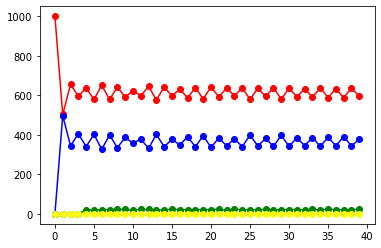

In [27]:
plt.plot(lista_t,l_alive,color='red',marker='o')
plt.plot(lista_t,l_enough,color='blue',marker='o')
plt.plot(lista_t,l_satisfied,color='green',marker='o')
plt.plot(lista_t,l_luxury,color='yellow',marker='o')